['mZ (1) @ alpha=0.005; beta=0', 'mZ (1) @ alpha=0.005; beta=0.01', 'mZ (1) @ alpha=0.005; beta=0.02', 'mZ (1) @ alpha=0.005; beta=0.04', 'mZ (1) @ alpha=0.005; beta=0.08', 'mZ (1) @ alpha=0.005; beta=0.12', 'mZ (1) @ alpha=0.005; beta=0.2', 'mZ (1) @ alpha=0.005; beta=0.3', 'mZ (1) @ alpha=0.01; beta=0', 'mZ (1) @ alpha=0.01; beta=0.01', 'mZ (1) @ alpha=0.01; beta=0.02', 'mZ (1) @ alpha=0.01; beta=0.04', 'mZ (1) @ alpha=0.01; beta=0.08', 'mZ (1) @ alpha=0.01; beta=0.12', 'mZ (1) @ alpha=0.01; beta=0.2', 'mZ (1) @ alpha=0.01; beta=0.3', 'mZ (1) @ alpha=0.02; beta=0', 'mZ (1) @ alpha=0.02; beta=0.01', 'mZ (1) @ alpha=0.02; beta=0.02', 'mZ (1) @ alpha=0.02; beta=0.04', 'mZ (1) @ alpha=0.02; beta=0.08', 'mZ (1) @ alpha=0.02; beta=0.12', 'mZ (1) @ alpha=0.02; beta=0.2', 'mZ (1) @ alpha=0.02; beta=0.3', 'mZ (1) @ alpha=0.04; beta=0', 'mZ (1) @ alpha=0.04; beta=0.01', 'mZ (1) @ alpha=0.04; beta=0.02', 'mZ (1) @ alpha=0.04; beta=0.04', 'mZ (1) @ alpha=0.04; beta=0.08', 'mZ (1) @ alpha=0.04; b

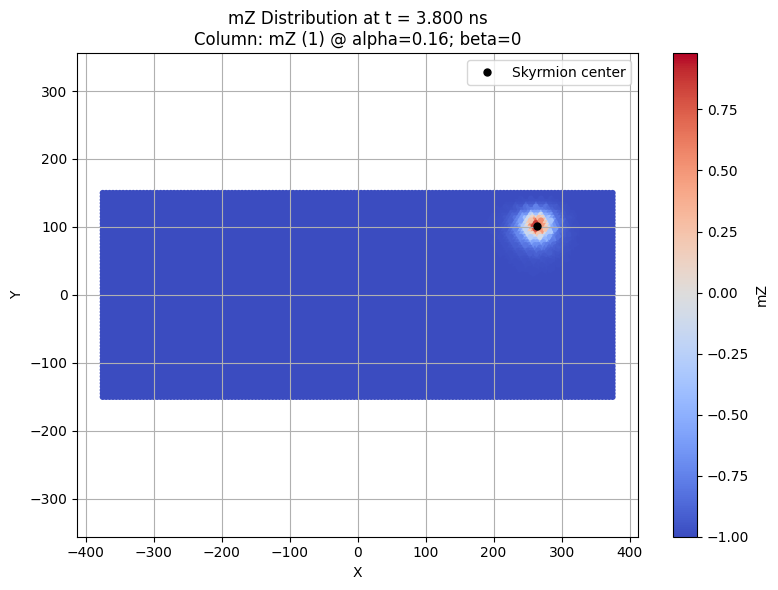

In [14]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# ====== Skyrmion 中心检测函数 ======
def find_skyrmion_center_by_clustering(df,
                                       mz_col=None,
                                       x_col="% X", y_col="Y",
                                       threshold=0.3,
                                       eps=8.0, min_samples=5):
    if mz_col is None:
        mz_candidates = [col for col in df.columns if 'mZ' in col and '@' in col]
        if not mz_candidates:
            raise ValueError("未找到 mZ 列")
        mz_col = mz_candidates[0]

    df_high = df[df[mz_col] > threshold].copy()
    if df_high.empty:
        return np.nan, np.nan, np.nan

    coords = df_high[[x_col, y_col]].values
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    df_high["cluster"] = clustering.labels_

    valid_clusters = df_high[df_high["cluster"] != -1]["cluster"]
    if valid_clusters.empty:
        return np.nan, np.nan, np.nan

    main_cluster = valid_clusters.value_counts().idxmax()
    df_main = df_high[df_high["cluster"] == main_cluster]

    x_center = df_main[x_col].mean()
    y_center = df_main[y_col].mean()
    mz_avg = df_main[mz_col].mean()

    return x_center, y_center, mz_avg


# ===== 1. 加载数据 =====
file_path = "../Data_Preprocessing/Image/Bloch_STT_1e-3_100nm//skx_3frames_jx=1e12.csv"
df = pd.read_csv(file_path)

# ===== 2. 识别所有 mZ 列 =====
mz_candidates = [col for col in df.columns if 'mZ' in col and '@' in col]

print(mz_candidates)
# ===== 3. 用户选择：要使用哪个 mZ 列（通过索引）=====
mz_index = 40  # 例如用第 0 个 mZ 列
mz_col = mz_candidates[mz_index]
print(f"✅ 使用的 mZ 列是: {mz_col}")

# ===== 4. 选择时间帧 =====
t_array = np.sort(df["t"].unique())
target_time = t_array[2]  # 例如选中间帧，可改为 0 或 2
print(f"✅ 当前绘制时间: t = {target_time:.2e} s")

df_singleframe = df[df["t"] == target_time].copy()

# ===== 5. 计算 Skyrmion 中心点 =====
x_center, y_center, _ = find_skyrmion_center_by_clustering(
    df_singleframe,
    mz_col=mz_col,
    x_col="% X",
    y_col="Y",
    threshold=0.3,
    eps=8.0,
    min_samples=5
)

# ===== 6. 准备绘图 =====
X = df_singleframe["% X"]
Y = df_singleframe["Y"]
mZ = df_singleframe[mz_col]

plt.figure(figsize=(8, 6))
sc = plt.scatter(X, Y, c=mZ, cmap="coolwarm", s=20, edgecolors='none')
plt.colorbar(sc, label="mZ")
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"mZ Distribution at t = {target_time*1e9:.3f} ns\nColumn: {mz_col}")
plt.axis("equal")
plt.grid(True)

if not np.isnan(x_center) and not np.isnan(y_center):
    plt.plot(x_center, y_center, 'ko', markersize=5, label="Skyrmion center")
    plt.legend()

plt.tight_layout()
plt.show()
